In [17]:
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

# Setup Dataset

In [18]:
train_data = datasets.MNIST(root='mnist', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.MNIST(root='mnist', train=False, download=True, transform=transforms.ToTensor())
print(train_data.data.shape), print(test_data.data.shape)

# Data loaders
loaders = {
	'train': DataLoader(train_data, batch_size=100, shuffle=True, num_workers=1),
	'test': DataLoader(test_data, batch_size=100, shuffle=True, num_workers=1)
}

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


# Build Model

In [47]:
class MNISTModel(nn.Module):
	def __init__(self):
		super(MNISTModel, self).__init__()
		self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
		self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
		self.conv2_drop = nn.Dropout2d()
		self.fc1 = nn.Linear(320, 50)
		self.fc2 = nn.Linear(50, 10)

	def forward(self, x):
		x = F.relu(F.max_pool2d(self.conv1(x), 2)) # Layer 1
		x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2)) # Layer 2
		x = x.view(-1, 320)
		x = F.relu(self.fc1(x)) # Layer 3
		x = self.fc2(F.dropout(x, training=self.training)) # Layer 4
		return F.softmax(x)
	
device = "cuda" if torch.cuda.is_available() else "cpu"
model = MNISTModel().to(device)

# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train

In [48]:
from tqdm import tqdm

def train(epoch):
	model.train()
	loop = tqdm(loaders['train'], leave=False)
	for data, target in loop:
		data, target = data.to(device), target.to(device)
		results = model(data)
		optimizer.zero_grad()
		loss = loss_fn(results, target)
		loss.backward()
		optimizer.step()
		loop.set_description(f"Epoch {epoch}")
		loop.set_postfix(loss=loss.item())

def test():
	model.eval()
	test_loss = 0
	correct = 0

	with torch.inference_mode():
		for data, target in loaders['test']:
			data, target = data.to(device), target.to(device)
			results = model(data) # Forward pass
			test_loss += loss_fn(results, target).item()
			pred = results.argmax(dim=1, keepdim=True)
			correct += pred.eq(target.view_as(pred)).sum().item()

	test_loss /= len(loaders['test'].dataset)
	accuracy = correct / len(loaders['test'].dataset)
	print(f"Test Loss {test_loss} | Accuracy {accuracy}")

In [49]:
epochs = 15
for epoch in range(1, epochs + 1):
	train(epoch)

test()

  0%|          | 0/600 [00:00<?, ?it/s]C:\Users\tshar\AppData\Local\Temp\ipykernel_13808\3187653465.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Test Loss 0.014861737215518952 | Accuracy 0.9751


# Predicting

torch.Size([1, 28, 28])
torch.Size([1, 1, 28, 28])
Prediction: 5 | Target: 5


C:\Users\tshar\AppData\Local\Temp\ipykernel_13808\3187653465.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


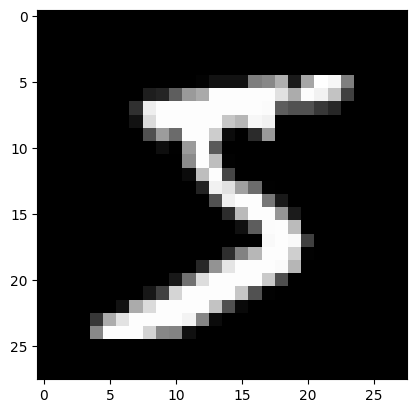

In [50]:
import matplotlib.pyplot as plt

model.eval()
data, target = train_data[0]
print(data.shape)
data = data.unsqueeze(0).to(device)
output = model(data)
pred = output.argmax(dim=1, keepdim=True)
print(data.shape)
print(f"Prediction: {pred.item()} | Target: {target}")
plt.imshow(data.squeeze(0).squeeze(0).cpu().numpy(), cmap='gray')

# Save / Load Model

In [51]:
import pathlib

# Save the model
pathlib.Path('models').mkdir(exist_ok=True)
torch.save(model.state_dict(), 'models/mnist_cnn.pth')

# torch.jit.save(torch.jit.script(model), 'models/mnist_cnn.pth')

In [52]:
# Load the model
model = MNISTModel().to(device)
model.load_state_dict(torch.load('models/mnist_cnn.pth'))

<All keys matched successfully>

# Custom Images

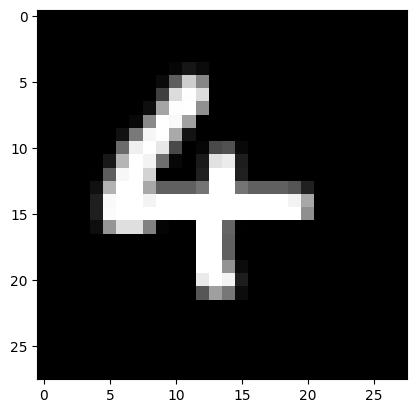

In [83]:
import cv2

img = cv2.imread('4.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img, (28, 28))
img = cv2.bitwise_not(img) # flip the image
plt.imshow(img, cmap='gray')

In [143]:
img_tensor = torch.from_numpy(img)
img_tensor = img_tensor.unsqueeze(0).unsqueeze(0).float()
img_tensor = img_tensor.to(device)
output = model(img_tensor)
# acc = 0
# for i in range(10000):
# 	pred = output.argmax(dim=1, keepdim=True)
# 	if pred.item() == 4:
# 		acc += 1

pred = output.argmax(dim=1, keepdim=True)
# print(f"Accuracy: {acc}%")
print(f"Prediction: {pred.item()}")

Prediction: 4


C:\Users\tshar\AppData\Local\Temp\ipykernel_13808\3187653465.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)
